# TSICE explanations 

`TSICEExplainer` is a model agnostic, black box forecaster explainer and provides local explanations for time series data. 
This algorithm adapts traditional Individual Conditional Expectation plot to time series modality. Timeseries data is highly correlated. Many algorithms often use features derived from the timeseries for forecasting. But these features cannot be changed independently. The TSICE relies on temporally focused sampling method (via timeseries perturbation) to explore this feature space and establishes the connection from this feature space to the model output.

The TSICE implementation implementation included in TrustyAI was developed by the [IBM's AIX360](https://github.com/Trusted-AI/AIX360) team and is available by installing the TrustyAI's `[extras]` dependencies.

The following examples are adapted from the [IBM's AIX360 examples](https://github.com/Trusted-AI/AIX360/tree/master/examples/tsice).

<a id='imports'></a>
### Imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import utils.plots as plots

from trustyai.explainers.extras.tsice import TSICEExplainer
from trustyai.utils.extras.timeseries import tsFrame

<a id='load_dataset'></a>
### Load Sunspot Dataset
- This example notebook uses sunspot dataset, a univariate dataset.
- The `sunspots` dataset loads the monthly **sunspots** (`df`) recorded between the year 1749 to 1983. For more information on sunspots, you can refer to [Avishek Pal, PKS Prakash, "Practical Time Series Analysis"](https://github.com/PacktPublishing/Practical-Time-Series-Analysis/), [R-sunspots](https://r-data.pmagunia.com/dataset/r-dataset-package-datasets-sunspots) and [other articles](https://en.wikipedia.org/wiki/Sunspot).
- TSICE expects the input time series in `tsFrame` data format. `aix360` exposes `tsFrame` utility that converts a regular time series to `DateTimeIndex` indexed `pd.DataFrame`.
- Split the univariate time series into sequential train and test subsets using `sklearn.model_selection.train_test_split` without shuffle.

In [2]:
df = pd.read_csv("data/sunspots.zip", compression="zip", usecols=['Date', 'Monthly Mean Total Sunspot Number'])
df.columns = ['month', 'sunspots']
df['month'] = pd.to_datetime(df['month'], format='%Y-%m-%d')

sunspot_ts_frame = tsFrame(df, timestamp_column='month', columns=['sunspots'])

ts_train, ts_test = train_test_split(sunspot_ts_frame,
                                     shuffle=False,
                                     stratify=None,
                                     test_size=0.15,
                                     train_size=None,
                                    )
    
sunspot_ts_frame.head(2)

,sunspots
month,
1749-01-31,96.7
1749-02-28,104.3


<a id='plot_sunspot_data'></a>
### Plot Sunspot Data

Below cell plots the sonspot time series data using `plotly` library.

<AxesSubplot: xlabel='month'>

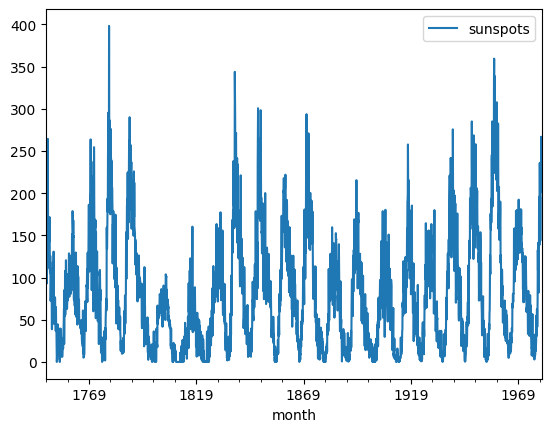

In [3]:
df_timestamps = sunspot_ts_frame.index.to_series()
df_timestamp_name = sunspot_ts_frame.index.name
df_targets = sunspot_ts_frame.columns.tolist()
df_description = "monthly count of the number of observed sunspots for just over 230 years (1749-1983)"

plot_x_start_indx = 0
plot_x_end_indx = -1

ts_train[plot_x_start_indx:plot_x_end_indx].plot()

<a id='train_forecaster'></a>
### Train Forecaster
For simplicity, use a simpler random forest regressor based forecaster which is available in open source forum and can be prepared quickly.

In [4]:
# transform a time series dataset into a supervised learning dataset
# below sample forecaster is from: https://machinelearningmastery.com/random-forest-for-time-series-forecasting/
class RandomForestUniVariateForecaster:
    def __init__(self, n_past=4, n_future=1, params={"n_estimators": 250}):
        self.n_past = n_past
        self.n_future = n_future
        self.model = RandomForestRegressor(**params)

    def fit(self, X):
        train = self._series_to_supervised(X, n_in=self.n_past, n_out=self.n_future)
        trainX, trainy = train[:, : -self.n_future], train[:, -self.n_future :]
        self.model = self.model.fit(trainX, trainy)
        return self

    def _series_to_supervised(self, data, n_in=1, n_out=1, dropnan=True):
        n_vars = 1 if type(data) is list else data.shape[1]
        df = pd.DataFrame(data)
        cols = list()

        # input sequence (t-n, ... t-1)
        for i in range(n_in, 0, -1):
            cols.append(df.shift(i))
        # forecast sequence (t, t+1, ... t+n)
        for i in range(0, n_out):
            cols.append(df.shift(-i))
        # put it all together
        agg = pd.concat(cols, axis=1)
        # drop rows with NaN values
        if dropnan:
            agg.dropna(inplace=True)
        return agg.values

    def predict(self, X):
        row = X[-self.n_past :].flatten()
        y_pred = self.model.predict(np.asarray([row]))
        return y_pred


It is observed that sunspots have a solar cycle of 11 years on average. We are training univariate random forest forecaster with 12 years input length to produce 12 month look ahead. 

In [5]:
input_length = 144 # 12 years
forecast_horizon = 12 # 1 year
forecaster = RandomForestUniVariateForecaster(
    n_past=input_length, n_future=forecast_horizon
)

_ = forecaster.fit(ts_train)

Below cell computes forecasts using a rolling window over the test data.

In [6]:
test_data = ts_test.values
y_test = []
predictions = []
for i in range(0, len(test_data)- input_length - forecast_horizon + 1):
    x_batch = test_data[i : i + input_length]
    x_batch_y = test_data[i + input_length : i + input_length + forecast_horizon].reshape(1,-1)
    y_test.append(x_batch_y)
    prediction = forecaster.predict(x_batch)
    predictions.append(prediction)

Below cell computes Root Mean Squared Error(RMSE) and coefficient of determination (R2)

In [7]:
from sklearn.metrics import r2_score

rmse = np.mean(np.sqrt(np.mean(np.square(np.concatenate(y_test, axis=0) - np.concatenate(predictions, axis=0)), axis=1)))
r2 = r2_score(np.concatenate(y_test, axis=0), np.concatenate(predictions, axis=0))

print("Test R2: {:.2f}".format(r2))
print("Test RMSE: {:.2f}".format(rmse))

Test R2: 0.83
Test RMSE: 19.83


<a id='initialize_tsice_range'></a>
### Initialize TSICEExplainer With A Range Window

`TSICEExplainer` uses TSPerturber for generating perturbed/simulated data and TSFeatures (Latest/RangeFeature) to derive time series structural features for further analysis. The `TSICEExplainer` explains the trend in the model forecast change by varying the selected part of the time series.  

Available perturbers are "block-bootstrap", "frequency", "moving_average", "shift". Available aggregation metrics (stats) are "median", "mean", "min", "max", "std", "range", "intercept", "trend", "rsquared", "max_variation". `explanation_window_start` and `explanation_window_length` are used to select observation window for explanation. 

In the following cells, we are measuring the impact of sunspots from 1975 and 1976 in the provided 12 years input time window (1972-1983) on the forecast horizon (next 1 year of 1984).

In [8]:
from aix360.algorithms.tsutils.tsperturbers import BlockBootstrapPerturber

observation_length = 24 # 2 years
explainer = TSICEExplainer(
            model=forecaster.predict,
            explanation_window_start=36, # 3 years
            explanation_window_length=observation_length,
            features_to_analyze=[
                'mean', # analyze mean metric from recent time series of lengh <observation_length> 
                'std', # analyze std metric from recent time series of lengh <observation_length> 
                'max_variation', # analyze max_variation metric from recent time series of lengh <observation_length> 
                'trend', # analyze trend metric from recent time series of lengh <observation_length> 
            ],
            perturbers=[
                BlockBootstrapPerturber(window_length=5, block_length=5, block_swap=2),
            ],
            input_length=input_length,
            forecast_lookahead=forecast_horizon,
            n_perturbations=250,
        )

<a id='compute_explanation_range'></a>
### Compute Explanation With Range

`TSICEExplainer` produces sensitivity based local explanation. `explain_instance` method expects `tsFrame` as input. The input data must be of length `input_length` that is configured in forecaster model.

In [11]:
explanation = explainer.explain_instance(
    ts=ts_test[-(input_length):],
)

<a id='plot_explanation_range'></a>
### Plot Explanation With Range

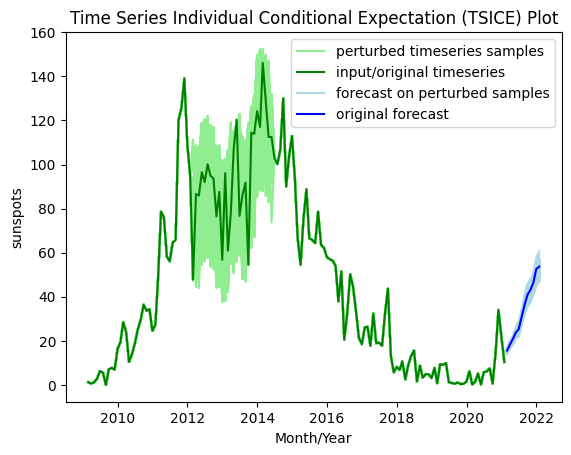

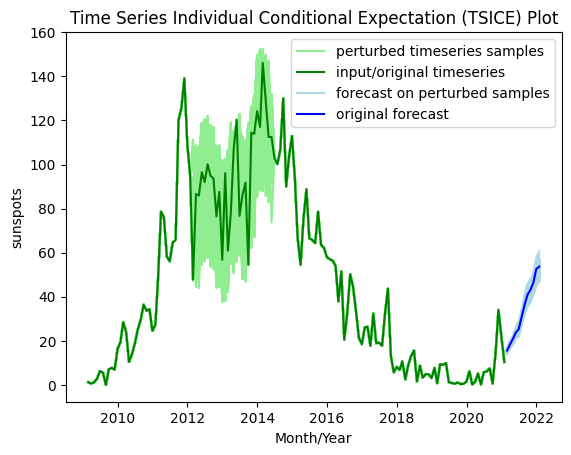

In [12]:
plots.plot_tsice_explanation(explanation, forecast_horizon=forecast_horizon)

The above TSICE plot explains that the sunspots from 1975 and 1976 do not have significant impact on the forecasted sunspots in 1984.

As comparing multiple timeseries directly is complicated, various data statistics computed on the timeseries data are often used to represent nature of the timeseries. TSICE uses these timeseries statistics as derived features to closely observe the impact of the above timeseries perturbations on the forecast. The suitability of the derived features depends on the  context/domain. The signed impact of derived feature(s) on forecasts is shown below plot. 

Signed impact (&#916; forecast) = mean of the forecasts over perturbations - mean of the original forecast.

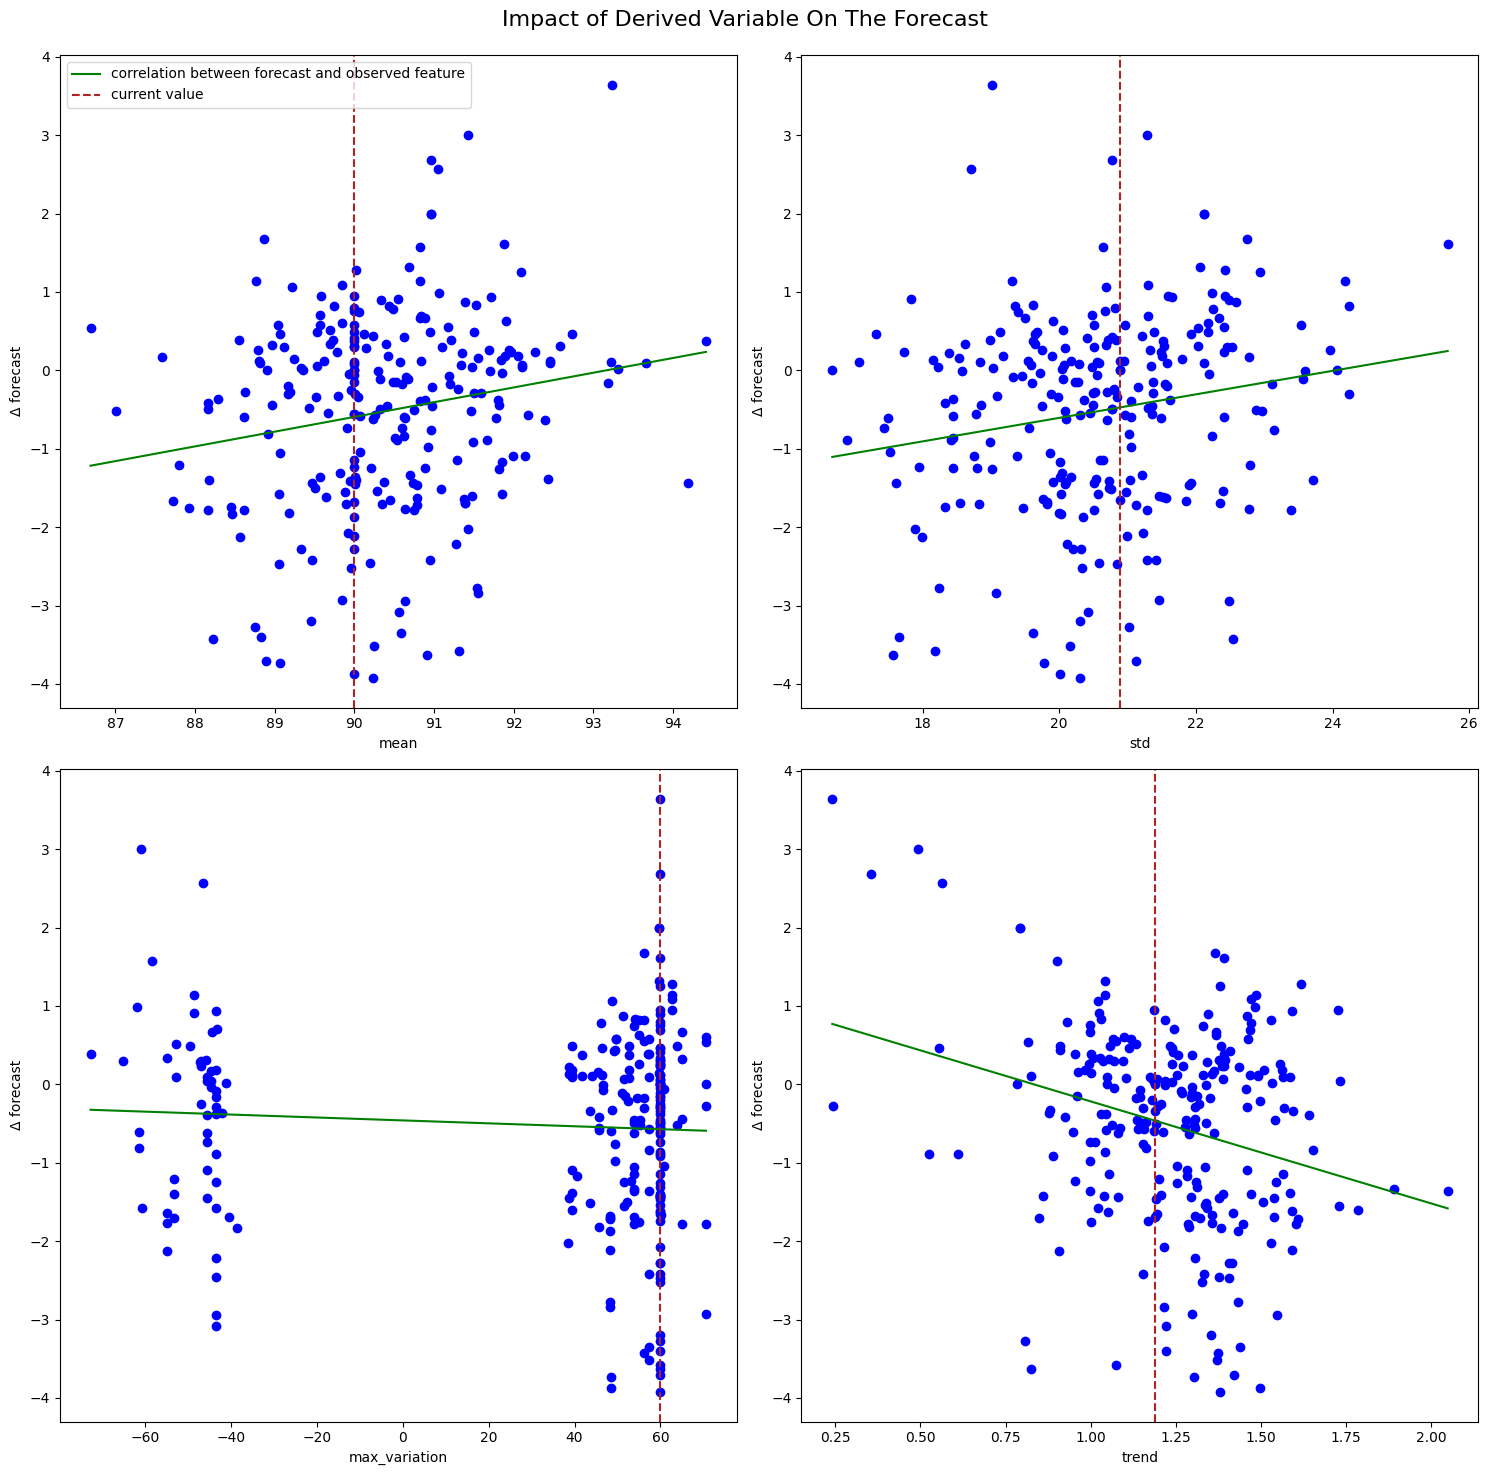

In [13]:
fig = plots.plot_tsice_with_observed_features(explanation)

The TSICE analysis shows that the sunpots data from 1975 and 1976 has very low impact on the forecasts of sunspots prediction in 1984. The linear trend of the data (1972-1983) has weak positive impact on the sunspots forecast of 1984.

<a id='initialize_tsice_latest'></a>
### Initialize TSICEExplainer With Latest Window
The following cells demonstrate the usage of TSICE to explain impact of latest part of the input timeseries. In these cells, we are explaining how the sunspots from 1982 and 1983 impact the sunspots forecasts of 1984.

In [14]:
observation_length = 24
explainer_with_latest_window = TSICEExplainer(
            model=forecaster.predict,
            explanation_window_start=None,
            explanation_window_length=observation_length,
            features_to_analyze=[
                'mean', # analyze mean metric from recent time series of lengh <observation_length> 
                'median', # analyze median metric from recent time series of lengh <observation_length> 
                'std', # analyze std metric from recent time series of lengh <observation_length> 
                'max_variation', # analyze max_variation metric from recent time series of lengh <observation_length> 
                'min',
                'max',
                'range',
                'intercept',
                'trend',
                'rsquared',
            ],
            perturbers=[
                dict(type="block-bootstrap", window_length=5, block_length=5, block_swap=2),
            ],
            input_length=input_length,
            forecast_lookahead=forecast_horizon,
            n_perturbations=250,
        )

<a id='compute_explanation_latest'></a>
### Compute Explanation With Latest

In [15]:
explanation_with_latest_window = explainer_with_latest_window.explain_instance(
    ts=ts_test[-(input_length):],
)

<a id='plot_explanation_latest'></a>
### Plot Explanation With Latest

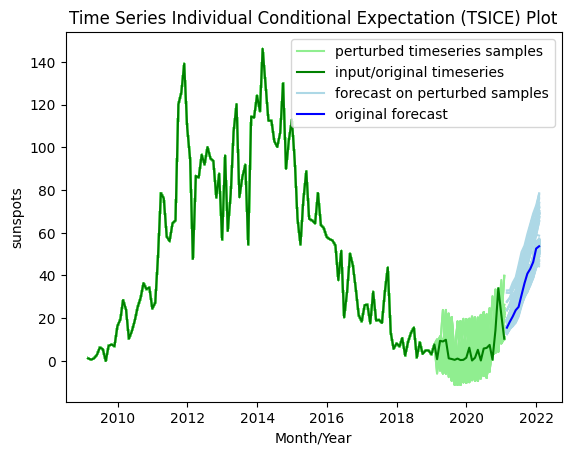

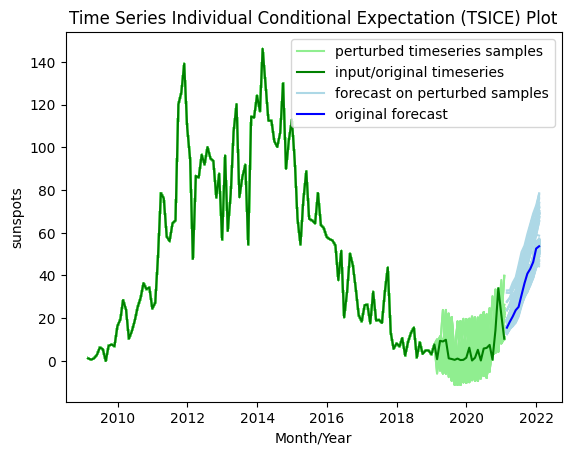

In [16]:
plots.plot_tsice_explanation(explanation_with_latest_window, forecast_horizon=forecast_horizon)

The above plot clearly shows that the sunspots from 1982 and 1983 have larger impact on the sunpots forecasts of 1984 compared to sunspots from 1975 and 1976.

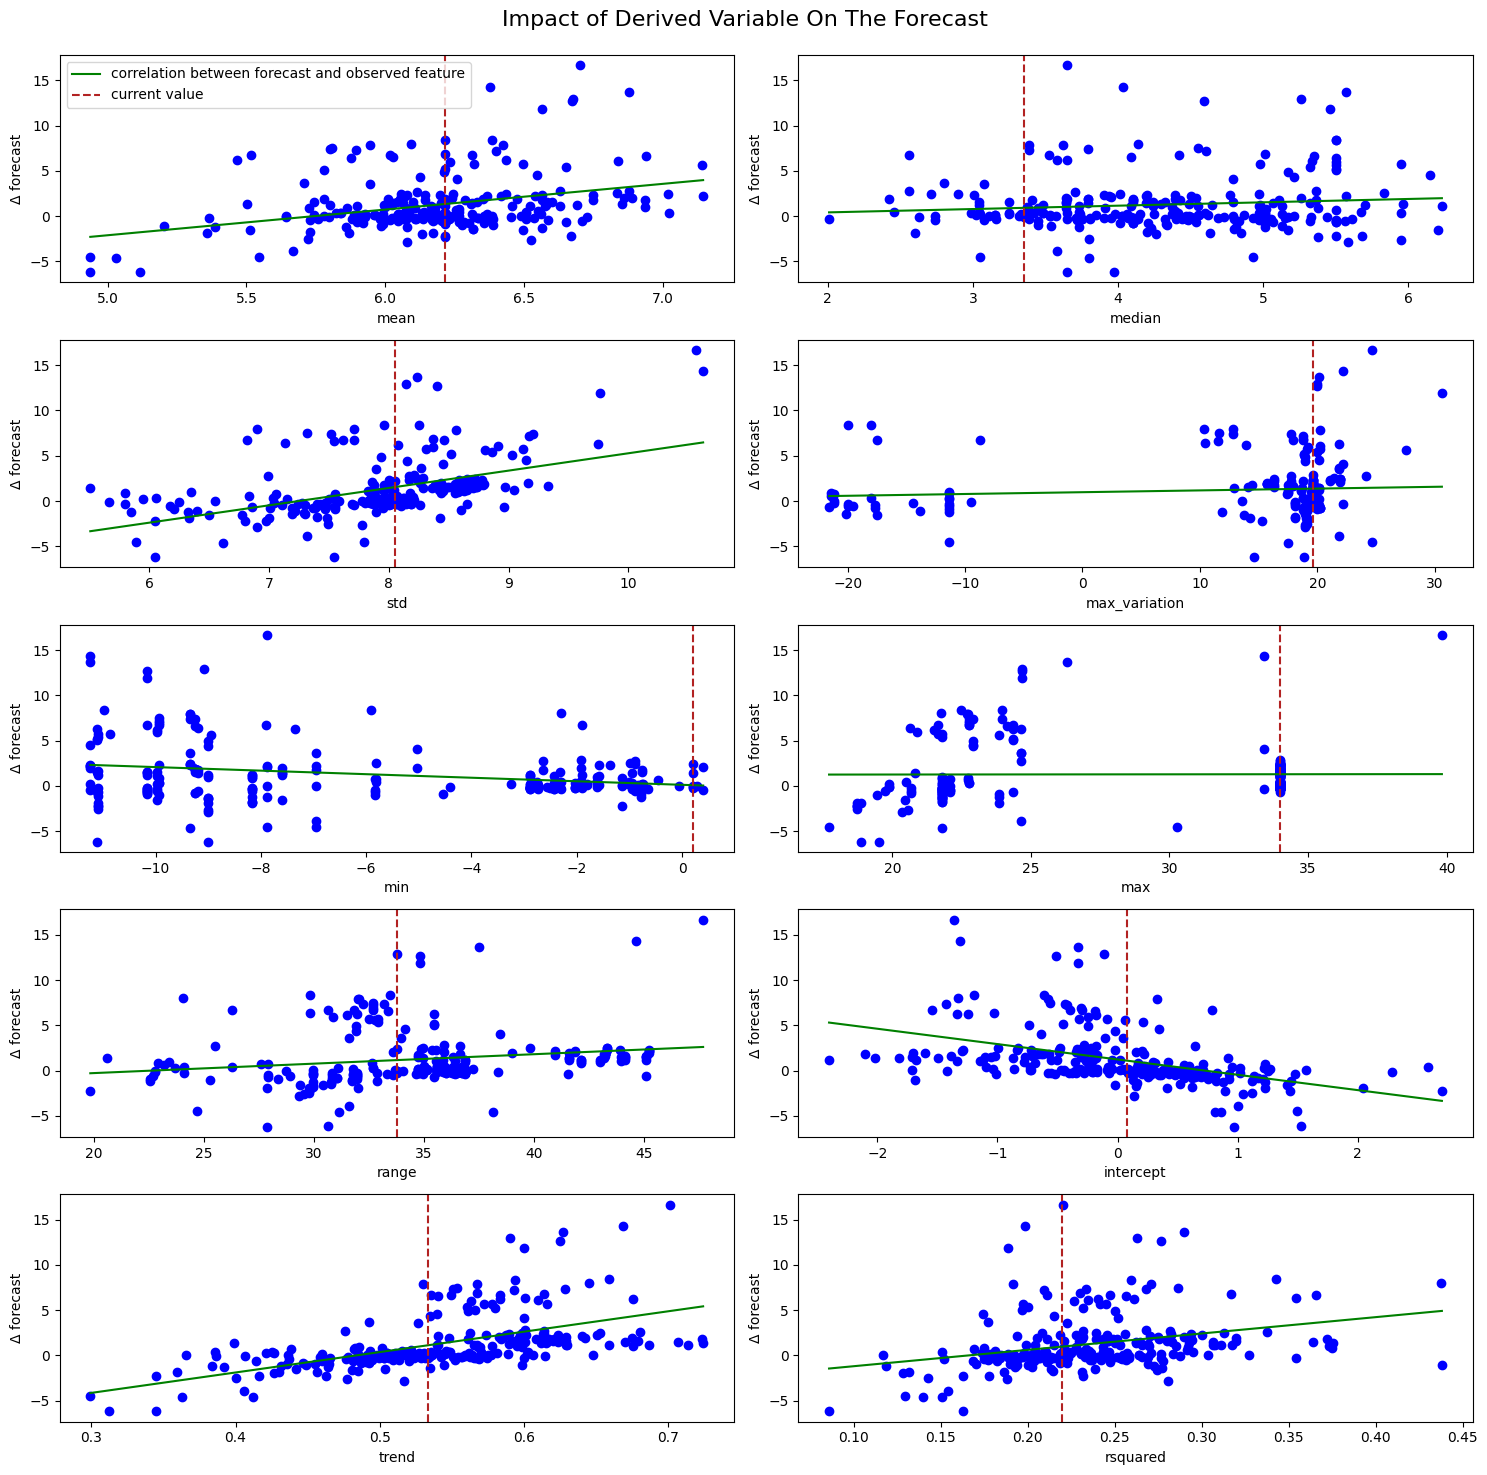

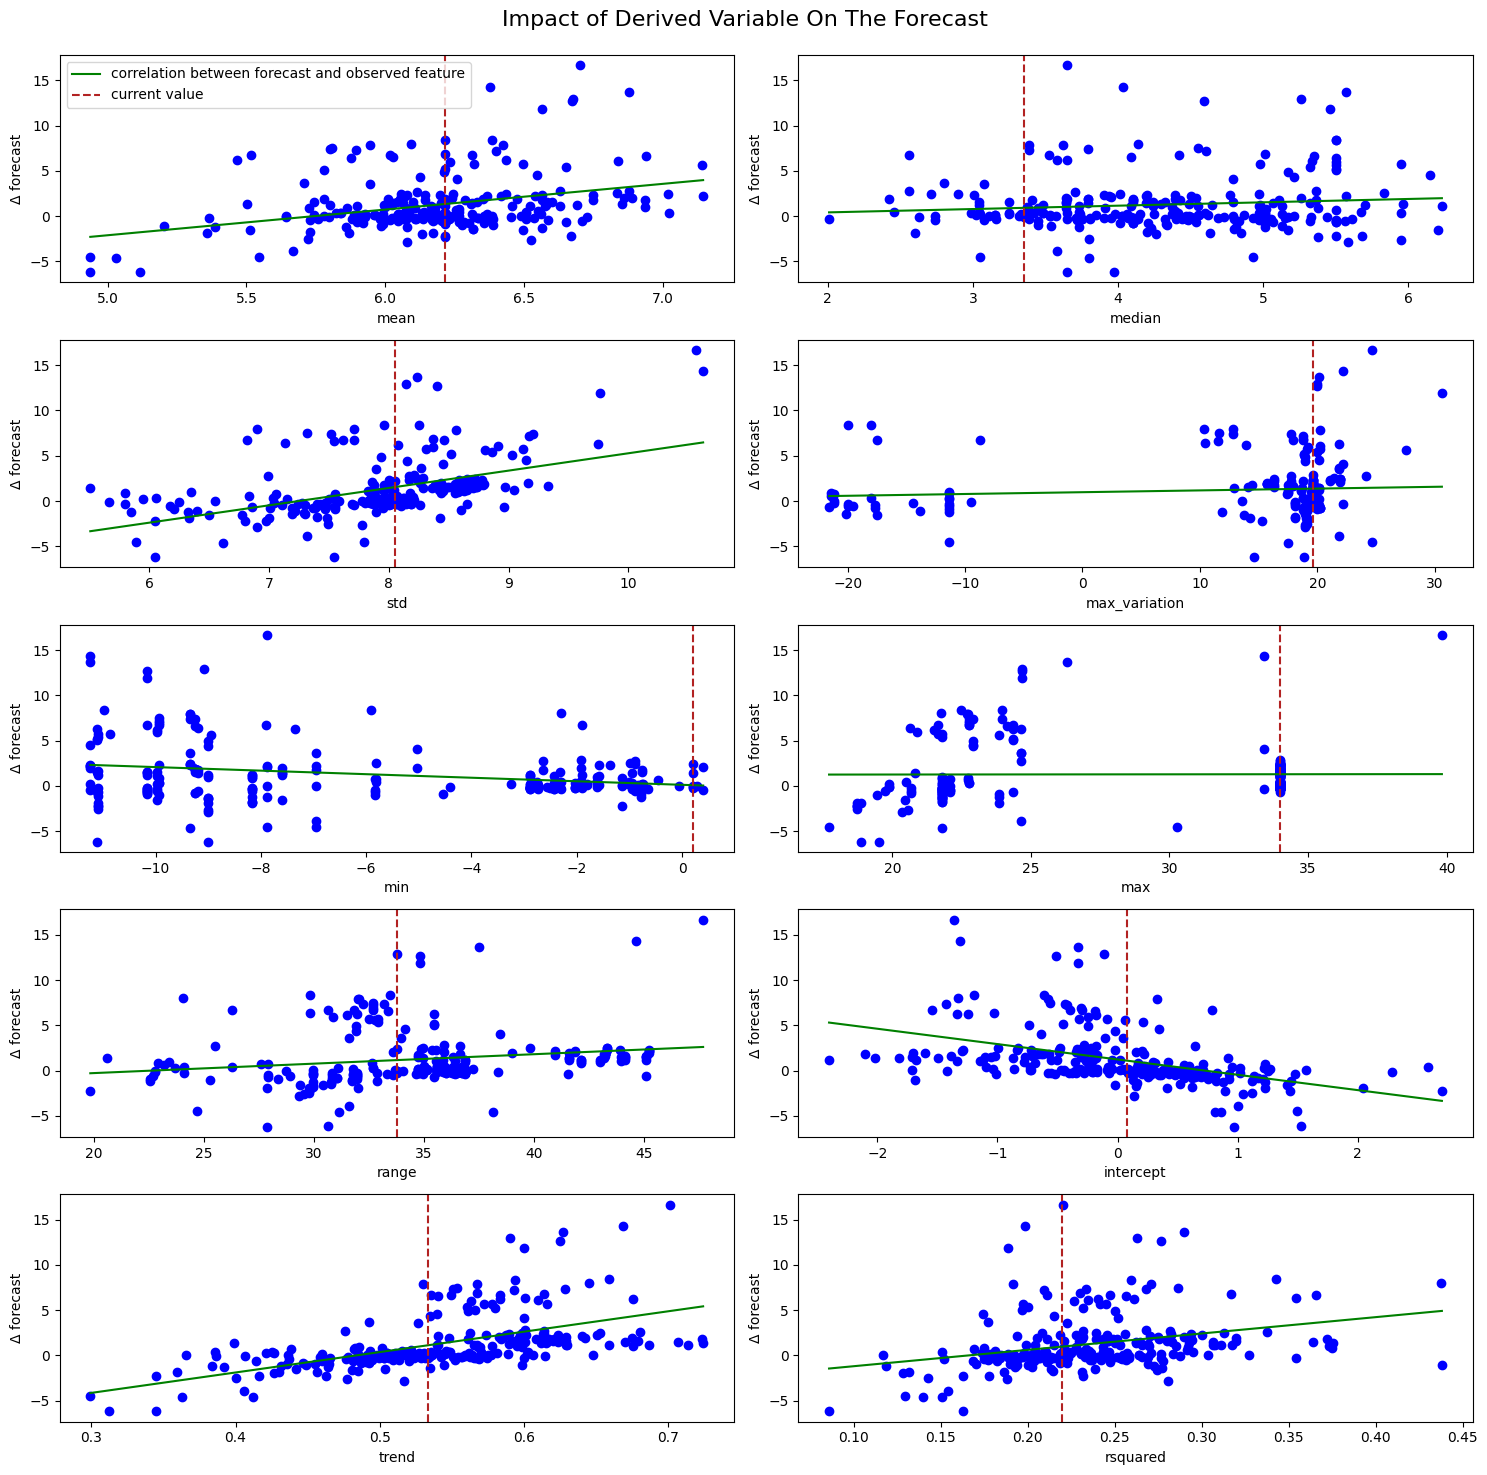

In [15]:
plots.plot_tsice_with_observed_features(explanation_with_latest_window)

The increased linear trend and minimum value reported over the years 1982 and 1983 positively impact the forecasts of 1984. The increase in the standard deviation and intercept features negatively impacts. 